In [2]:
#hide
import numpy as np 
from matplotlib import pyplot as plt
import pandas as pd

%matplotlib inline

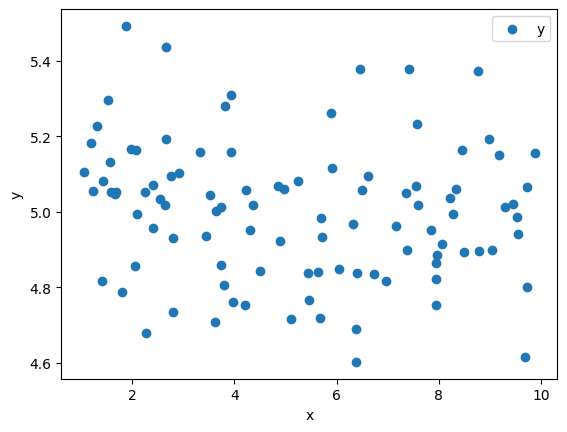

In [3]:
np.random.seed(42)
x = np.random.uniform(1, 10, 100)
y = np.random.normal(5, 0.2, size=x.shape)

## ask for what is the intetion of this line in Nicolas's code
plt.scatter(x,y, label='y')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

In [4]:
# model prediction
pred = 5
reg  = 0 # regularization

# g stands for gradient and h stands for hessian
# g = 2*(y-x)*x from the mean square error
g = np.array([2*(i-pred)*i for i in y])
h = np.array([-2*i for i in y])

# The optimal weight for the model is the negative sum of the gradient divided by the sum of the hessian
# We can see this in the XG Boost paper
w = -g.sum()/(h.sum()+ reg)

print(f'the optimal weight is {w:.4} for the model with a constant prediction of y={pred}')

the optimal weight is 0.006385 for the model with a constant prediction of y=5


In [5]:
# model prediction
pred = 1

# g stands for gradient and h stands for hessian
# g = 2*(y-x)*x from the mean square error
g = np.array([2*(i-pred)*i for i in y])
h = np.array([-2*i for i in y])

# The optimal weight for the model is the negative sum of the gradient divided by the sum of the hessian
# We can see this in the XG Boost paper
w = -g.sum()/(h.sum()+ reg)

print(f'the optimal weight is {w:.4} for the model with a constant prediction of y={pred}')

the optimal weight is 4.006 for the model with a constant prediction of y=1


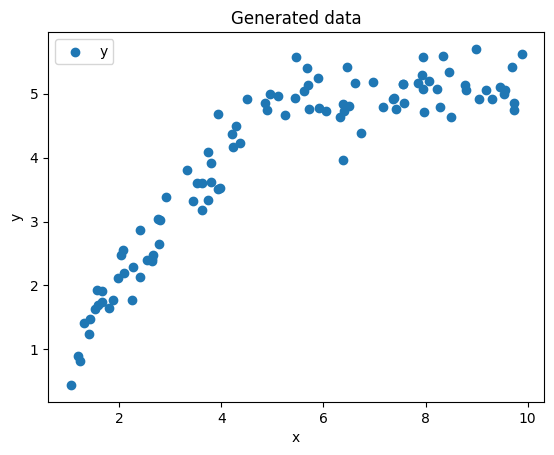

In [149]:

y = np.where(x < 5, x,5) + np.random.normal(0, 0.3, size=x.shape)
#x = x.reshape(-1,1)

df = pd.DataFrame({"X":x,"y":y})

plt.scatter(df["X"],df["y"], label='y')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Generated data')
plt.legend();

In [7]:
f_0 = np.mean(y) # initial prediction using the mean of the target

#Compute gradient and hessian of each sample
df["g"] = 2*(df["y"]-f_0)/len(df["y"])  # is this correct?
df["h"] = -2/len(df["y"])               # is this correct?


df = df.sort_values(by=['X'])
df.reset_index(inplace = True, drop = True)
#df.reset_index(inplace = True, drop = True) # We are not using the index anymore

#Keep track of the loss
l = [] 

#Test the different threshold, this is to find the optimal threshold to split the data
# Each threshold will be tested on the whole dataset
for i in range(len(df)):
    
    # select the threshold to split the data
    t = df["X"][i]
    df_L =  df[df["X"]<t]
    df_R =  df[df["X"]>=t]
    
    G, H =np.sum(df["g"]), np.sum(df["h"])
    
    G_L = np.sum(df_L["g"])
    G_R = np.sum(df_R["g"])
    
    H_L = np.sum(df_L["h"])
    H_R = np.sum(df_R["h"])
    
    if (H==0) or (H_R==0) or (H_L ==0):
        continue
    
    # Compute the contribution of the split to the loss
    # check the XG Boost paper for the formula
    split = 1/2*((G_L**2)/H_L + (G_R**2)/H_R - (G**2)/H)
    
    l.append(split)
    
    opt_split = min(opt_split, split)
    
    if split == opt_split:
        x_opt = df["X"][i]

print(f'The optimal threshold value of {x_opt:.4}')
plt.plot(df["X"][1:],l)
plt.title("Split impact on loss for different threshold values")
plt.xlabel("Threshold value")
plt.ylabel("Split impact")

NameError: name 'opt_split' is not defined

In [8]:

#Compute the new leaf weights
def split(df, x_opt):
    # split the data into two parts
    df_left  = df[df["X"]<x_opt]
    df_right = df[df["X"]>x_opt]
    # compute the gradient and hessian for each part
    G_Left = np.sum(df_left["g"])
    H_Left = np.sum(df_left["h"])
    
    G_Right = np.sum(df_right["g"])
    H_Right = np.sum(df_right["h"])

    w_left = -G_Left/H_Left
    w_right = -G_Right/H_Right
    
    return w_left, w_right

w_left, w_right = split(df, x_opt)

print(f'The optimal weight for the left leaf is {w_left:.4}')
print(f'The optimal weight for the right leaf is {w_right:.4}')

NameError: name 'x_opt' is not defined

In [9]:
f_1 = []

for i in df["X"]: 
    if i<x_opt:
        f_1.append(f_0 + w_left)
    else :
        f_1.append(f_0 + w_right)

plt.figure()
plt.scatter(df["X"],df["y"])
plt.plot(df["X"],f_1, color = "red")

NameError: name 'x_opt' is not defined

In [10]:
df

,X,y,g,h
0,1.049699,1.579335,-0.047499,-0.02
1,1.185260,1.327232,-0.052541,-0.02
2,1.228772,0.934320,-0.060400,-0.02
3,1.309497,1.163888,-0.055808,-0.02
4,1.407046,2.050229,-0.038082,-0.02
...,...,...,...,...
95,9.556429,5.436060,0.029635,-0.02
96,9.690688,5.171267,0.024339,-0.02
97,9.726262,5.019284,0.021300,-0.02
98,9.729189,4.978151,0.020477,-0.02


In [134]:

def generate_histograms(X, y, y_pred , n_bins = 10):
        """Generate the histogram representation of the data
        
        Returns:
        client_df: The dataframe of the client data with the gradient and hessian
        histograms: The histogram representation of the data per feature
                    histograms[i] = histogram of feature i. Each histogram is a dataframe with the following columns:
                                    "feature": the feature name
                                    "gradient": the gradient of the objective function for the feature
                                    "hessian": the hessian of the objective function for the feature
                                    "bin": the bin of the histogram
                                    the histogram for regression is the sum of the gradient and hessian
        """        
        
        ## Check if I need the y output if I already have the gradient and hessian
        client_df = pd.DataFrame(X)
        client_df["gradient"] = -2*(y.reshape(-1,1) - y_pred.reshape(-1,1))/ len(y)
        client_df["hessian"]  = 2/ len(y)
        
        # Must be a histogram for each feature
        histograms = [None]*(client_df.shape[1]-2)
        
        for i, feature in enumerate(client_df.columns):
            # skip the gradient and hessian
            if feature == "gradient" or feature == "hessian":
                continue
            # get the histogram of the feature and the gradient and hessian
            hist = client_df[[feature, "gradient", "hessian"]].copy()
            hist["bin"] = pd.qcut(client_df[feature], n_bins, duplicates = "drop") # check if should drop duplicates
            feat1 = hist.groupby("bin").agg({"gradient": "sum", "hessian": "sum"})
            feat1["bin"] = feat1.index.map(lambda x: x.mid).astype(float)
            histograms[i] = feat1.reset_index(drop = True)
            del hist # delete the hist dataframe to save memory
            
        return client_df, histograms

In [136]:
X = df["X"].values.reshape(-1,1)
y = df["y"].values.reshape(-1,1)
y_pred = y.mean()

client_df, histograms = generate_histograms(X, y, y_pred , n_bins = 25)
#feat1 = histograms[0].groupby("bin").agg({"gradient": "sum", "hessian": "sum"})
#feat1["bin"] = feat1.index.map(lambda x: x.mid).astype(float)
#feat1.reset_index(inplace = True, drop = True)
feat1 = histograms[0]
feat1

,gradient,hessian,bin
0,0.227780,0.08,1.2260
1,0.189606,0.08,1.4935
2,0.175918,0.08,1.7265
3,0.151356,0.08,1.9820
4,0.144255,0.08,2.2495
5,0.122863,0.08,2.5325
6,0.092239,0.08,2.7700
7,0.063463,0.08,3.2350
8,0.001514,0.08,3.6845
9,0.000873,0.08,3.8680


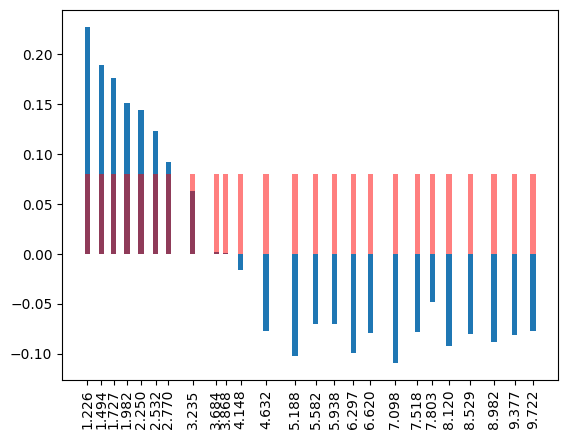

In [137]:
plt.bar(feat1["bin"], feat1["gradient"], width = 0.1)
plt.bar(feat1["bin"], feat1["hessian"], width = 0.1, color = "red", alpha = 0.5)
plt.xticks(feat1["bin"], rotation = 90)
plt.show()
plt.close()

In [138]:
def get_split_value_one_feature(histogram, lambda_ = 0.1, gamma = 0.1):
    """Compute the split value for a feature histogram
    
    Returns:
    split_value: the split value for the histogram
    """
    # Initialize the score for each bin
    
    score = [None]*len(histogram)
    # Compute the total gradient and hessian
    g = histogram["gradient"].sum()
    h = histogram["hessian"].sum()
    # Compute the score for each bin
    
    for i, bin_ in enumerate(histogram["bin"]):
        if i == 0:
            score[i] = 0
            continue
        # Gets the gradient and hessian for the left and right part of the histogram (wheights)
        g_left = histogram["gradient"][:i].sum()
        h_left = histogram["hessian"][:i].sum()
        
        g_right = histogram["gradient"][i:].sum()
        h_right = histogram["hessian"][i:].sum()
        
        # Compute the score for left and right part of the histogram
        score[i] = (g_left**2/(h_left + lambda_) + g_right**2/(h_right + lambda_) - g**2/(h + lambda_))*0.5 - gamma
    
    # Get the split value and the index of the split
    split_value = histogram["bin"][np.argmax(score)]
    index_split = score.index(max(score))
    # Compute the weights for the left and right part of the histogram
    w_left = -histogram["gradient"][:index_split].sum()/(histogram["hessian"][:index_split].sum() + lambda_)
    w_right = -histogram["gradient"][index_split:].sum()/(histogram["hessian"][index_split:].sum() + lambda_)
    
    return score , split_value, w_left, w_right

(-1.1225755246065492, 0.663340082722052)

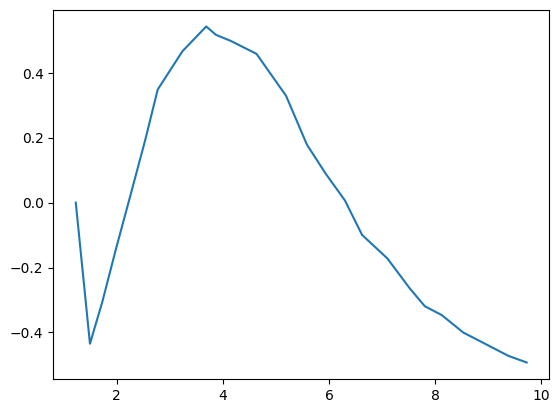

In [139]:
score , split_value, w_left, w_right = get_split_value_one_feature(feat1, lambda_ = 0.4, gamma = 0.5)
plt.plot(feat1["bin"], score)
w_left, w_right

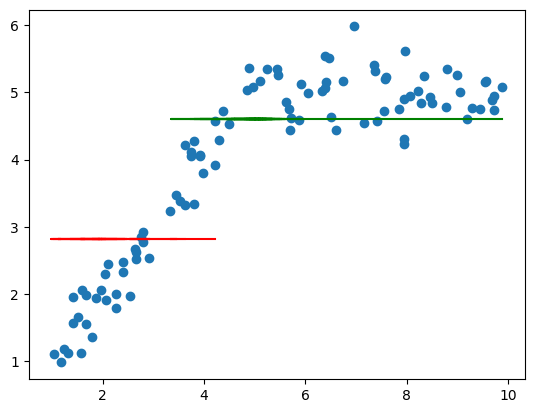

In [140]:
y_pred_1 = y_pred + w_left
y_pred_2 = y_pred + w_right
plt.figure()
plt.scatter(df["X"],df["y"])
plt.plot(df.where(df["X"]<=split_value), [y_pred_1]*len(df.where(df["X"]<=split_value)), color = "red")
plt.plot(df.where(df["X"]>split_value), [y_pred_2]*len(df.where(df["X"]>split_value)), color = "green")

next_hist1 = feat1.where(feat1["bin"]>split_value).dropna()
next_hist2 = feat1.where(feat1["bin"]<=split_value).dropna()

In [141]:
trees = pd.DataFrame(columns = ["tree_n", "node_n" ,"feature", "ID", "depth", "split_value", "yes", "no", "missing", "gain_w"])


## first it will be symmetric, then I will add the missing values
# The histogram should be already built for each feature, it includes the gradient and hessian
def build_tree(trees, X_hist, lambda_ = 0.1, gamma = 0.1, max_depth = 3, max_leaves = 5):
    
    depth = 0
    leaves = 0 
    node = 0
    
    # Is the list of trees empty?
    if len(trees["tree_n"]) == 0:
        new_tree = 0
    else:
        new_tree = trees["tree_n"] + 1
    # Initialize the node number
    scores = []
        
    # check the depth and the number of leaves
    # Do a first split for the root node
    feature = np.random.choice(len(X_hist))
    ID = str(new_tree) + "-" + str(node)
    score , split_value, _, _ = get_split_value_one_feature(X_hist[feature], lambda_ , gamma)
    # Add the root node to the tree
    node += 1
    yes = str(new_tree) + "-" + str(node)
    node += 1
    no  = str(new_tree) + "-" + str(node)
    # Compute the gain for the split
    gain = -X_hist[feature]["gradient"].sum()**2/(X_hist[feature]["hessian"].sum() + lambda_) 
    #missing = str(new_tree) + "-" + str(node + 3)
    
    new = pd.DataFrame({"tree_n": new_tree,
                        "node_n": node-2,
                        "feature": feature,
                        "ID": ID,
                        "depth": depth,
                        "split_value": split_value,
                        "yes": yes,
                        "no": no,
                        "missing": None,
                        "gain_w": gain}, index = [0])
    
    trees = trees.append(new, ignore_index = True)
    
    depth += 1
    leaves += 2
    
    splits = [split_value]
    branch = 1
    feature1 = feature
    print(node)
    while depth <= max_depth:
        # Check the left node first
        # Get the histogram for the left node
        ID = str(new_tree) + "-" + str(node-1)
        
        X_hist_new = X_hist[feature][X_hist[feature]["bin"] <= split_value]
        # get the score for the left node
        score , split_value, gain, _ = get_split_value_one_feature(X_hist_new, lambda_ , gamma)
        gain = -X_hist_new["gradient"].sum()**2/(X_hist_new["hessian"].sum() + lambda_)
        node += 1
        yes = str(new_tree) + "-" + str(node)
        node += 1
        no  = str(new_tree) + "-" + str(node)
        leaves += 2
        # Compute the gain for the split
        if depth == max_depth -1 :
            feature = 'Leaf'
            yes = None
            no = None
        new = pd.DataFrame({"tree_n": new_tree,
                        "node_n": node-3,
                        "feature": feature,
                        "ID": ID,
                        "depth": depth,
                        "split_value": split_value,
                        "yes": yes,
                        "no": no,
                        "missing": None,
                        "gain_w": gain}, index = [0])
    
        trees = trees.append(new, ignore_index = True)
        splits.append(split_value)
        depth += 1
        if depth == max_depth and branch == 1:
        #     branch = 0
        #     depth = 1
        #     node = 3
        #     feature= int(feature1)
        # elif depth == max_depth and branch == 0:
            break
                
    return trees


In [142]:
tree1 = build_tree(trees, [feat1] , lambda_ = 0.1, gamma = 0.1, max_depth =4, max_leaves = 5)

2


C:\Users\hecma\AppData\Local\Temp\ipykernel_40220\612759317.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_40220\612759317.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_40220\612759317.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_40220\612759317.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)


In [143]:
tree1

,tree_n,node_n,feature,ID,depth,split_value,yes,no,missing,gain_w
0,0,0,0,0-0,0,3.6845,0-1,0-2,None,-1.695735e-31
1,0,1,0,0-1,1,1.2260,0-3,0-4,None,-1.666515e+00
2,0,3,0,0-3,2,1.2260,0-5,0-6,None,-2.882436e-01
3,0,5,Leaf,0-5,3,1.2260,None,None,None,-2.882436e-01


In [144]:
def predict_tree(tree, X, y_init ):
    for node in tree["feature"]:
        if node == "Leaf":
            return y_init + int(tree[tree["feature"] == "Leaf"]["gain_w"])
        else:
            pass                      
    
    return y_init + tree["gain_w"][node]

In [145]:
y_pred = predict_tree(tree1, df["X"], y_init = y.mean())

In [146]:
print(y_pred)

3.9447334284076994


In [152]:
### This is directly from Nicolas's code

def find_best_rule(histograms, lambda_ = 0.1, gamma = 0.1):
    
    #X_train with X, g and h for all samples
    feature = np.random.choice(len(histograms))
    score , split_value, _, _ = get_split_value_one_feature(histograms[feature], lambda_ , gamma)
    return {'feature': feature, 'threshold': split_value}


def split(histograms, depth, max_depth, lambda_ = 0.1, gamma = 0.1):
    
    if depth == max_depth or len(histograms) < 2:
        display(histograms)
        feature = np.random.choice(len(histograms))
        score , split_value, w_left, w_right = get_split_value_one_feature(histograms[feature], lambda_ , gamma)
        return {'feature': feature, 'threshold': split_value,'prediction': w_left}
    
    rule = find_best_rule(histograms, lambda_ = 0.1, gamma = 0.1)
    left_ix = histograms[rule['feature']] < rule['threshold']
    rule['left'] = split(histograms[rule['feature']][left_ix], depth + 1, max_depth)
    rule['right'] = split(histograms[rule['feature']][~left_ix], depth + 1, max_depth)
    return rule

def predict(sample, rules):
    prediction = None
    while prediction is None:
        feature, threshold = rules['feature'], rules['threshold']
        if sample[feature] < threshold:
            print(rules)
            rules = rules['left']
        else:
            rules = rules['right']
        prediction = rules.get('prediction', None)
    return prediction


def evaluate(X, y):
    preds = X.apply(predict, axis='columns', rules=rules.copy())
    return preds, y


def rss(y_left, y_right):
    def squared_residual_sum(y):
        return np.sum((y - np.mean(y)) ** 2)
    
    return squared_residual_sum(y_left) + squared_residual_sum(y_right) 

In [153]:

f_0 = np.mean(y)
f_m = f_0

#Build the tree
tree = split(histograms, depth = 2, max_depth = 3, lambda_ = 0.1, gamma = 0.1)

df = pd.DataFrame({"X":x,"y":y})

df = df.sort_values(by=['X'])
df.reset_index(inplace = True, drop = True)


#Predict the residuals 
preds = df.apply(predict, axis='columns', rules=tree.copy())


#New model predictions
f_m = f_m + preds
plt.figure()
plt.scatter(df["X"],df["y"])
plt.plot(df["X"],f_m, color = "red")

[    gradient  hessian     bin
 0   0.227780     0.08  1.2260
 1   0.189606     0.08  1.4935
 2   0.175918     0.08  1.7265
 3   0.151356     0.08  1.9820
 4   0.144255     0.08  2.2495
 5   0.122863     0.08  2.5325
 6   0.092239     0.08  2.7700
 7   0.063463     0.08  3.2350
 8   0.001514     0.08  3.6845
 9   0.000873     0.08  3.8680
 10 -0.015967     0.08  4.1480
 11 -0.077007     0.08  4.6320
 12 -0.102660     0.08  5.1880
 13 -0.070096     0.08  5.5815
 14 -0.070614     0.08  5.9385
 15 -0.099800     0.08  6.2975
 16 -0.079023     0.08  6.6205
 17 -0.109064     0.08  7.0980
 18 -0.078555     0.08  7.5180
 19 -0.048012     0.08  7.8025
 20 -0.092654     0.08  8.1205
 21 -0.080212     0.08  8.5285
 22 -0.088142     0.08  8.9820
 23 -0.080830     0.08  9.3775
 24 -0.077230     0.08  9.7220]

{'feature': 0, 'threshold': 3.6845, 'prediction': -1.577673710257853}


KeyError: 'left'

In [154]:
tree

{'feature': 0, 'threshold': 3.6845, 'prediction': -1.577673710257853}